In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
import keras_tuner
from sklearn.model_selection import train_test_split

In [52]:
seed_value = 4 # 4
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
SAVE_FIGURES = True

In [53]:
data = pd.read_csv('./training_data/TESTclean.csv')
spectra = np.array(data.iloc[:, 1:])
redshifts = np.array(data.iloc[:, 0])

In [54]:
# standard_scaler = StandardScaler()
# spectra = standard_scaler.fit_transform(spectra)
# quantile_transformer = QuantileTransformer(random_state=seed_value)
# spectra = quantile_transformer.fit_transform(spectra)
min_max_scaler = MinMaxScaler()
spectra = min_max_scaler.fit_transform(spectra)

spectra_train, spectra_test, redshift_train, redshift_test = train_test_split(spectra, redshifts, test_size=0.1, random_state=seed_value) # 0.9

In [55]:
# conv 256 5
# conv 256 5
# conv 128 3
# conv 64 2
# dense 256
# dense 256
# dense 128
# dense 64

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(186, 1)),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
])

model.compile(optimizer='adamax', loss='huber', metrics=['mean_absolute_error']) # adamax, huber

In [56]:
batch_size = 16 # 16
epochs = 40 # 30
validation_split = 0.3 # 0.3
history = model.fit(spectra_train, redshift_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

Epoch 1/40
20491/20491 [==============================] - 277s 13ms/step - loss: 6.8835e-04 - mean_absolute_error: 0.0262 - val_loss: 5.9763e-04 - val_mean_absolute_error: 0.0245
Epoch 2/40
20491/20491 [==============================] - 289s 14ms/step - loss: 5.9231e-04 - mean_absolute_error: 0.0240 - val_loss: 5.6907e-04 - val_mean_absolute_error: 0.0235
Epoch 3/40
20491/20491 [==============================] - 291s 14ms/step - loss: 5.6749e-04 - mean_absolute_error: 0.0235 - val_loss: 5.6399e-04 - val_mean_absolute_error: 0.0239
Epoch 4/40
20491/20491 [==============================] - 282s 14ms/step - loss: 5.5476e-04 - mean_absolute_error: 0.0231 - val_loss: 5.7055e-04 - val_mean_absolute_error: 0.0235
Epoch 5/40
20491/20491 [==============================] - 275s 13ms/step - loss: 5.4605e-04 - mean_absolute_error: 0.0230 - val_loss: 5.3143e-04 - val_mean_absolute_error: 0.0225
Epoch 6/40
20491/20491 [==============================] - 274s 13ms/step - loss: 5.4000e-04 - mean_absolu

In [57]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('./history.csv')
# model.save('./model.keras')
# model = tf.keras.models.load_model('./model.keras')

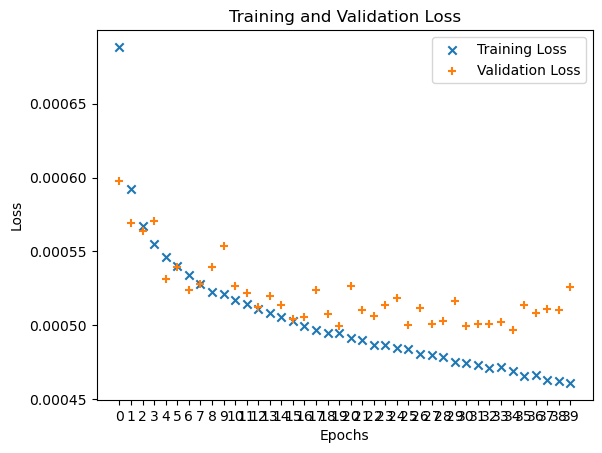

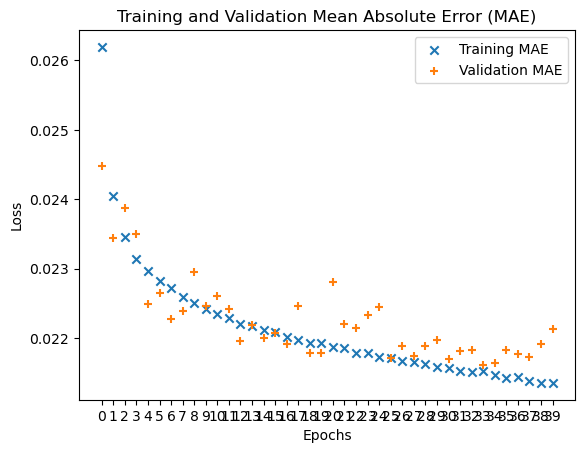

In [58]:
EPOCH_SKIP_PCT = 0
# if history.csv exists, load it
# if os.path.isfile('./history.csv'):
    # history_df = pd.read_csv('./history.csv')

plt.scatter(history_df.index, history_df['loss'], label='Training Loss', marker='x')
plt.scatter(history_df.index, history_df['val_loss'], label='Validation Loss', marker='+')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, epochs, 1))
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

if SAVE_FIGURES: plt.savefig('./graphs/training_loss.png')

plt.figure()
plt.scatter(history_df.index, history_df['mean_absolute_error'], label='Training MAE', marker='x')
plt.scatter(history_df.index, history_df['val_mean_absolute_error'], label='Validation MAE', marker='+')
plt.xlabel('Epochs')
plt.xticks(np.arange(0, epochs, 1))
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Mean Absolute Error (MAE)')
if SAVE_FIGURES: plt.savefig('./graphs/training_mae.png')

plt.show()

In [59]:
# spectra_to_predict = spectra_val
# redshifts_true = redshift_val
# spectra_to_predict = spectra
# redshifts_true = redshifts
spectra_to_predict = spectra_test
redshifts_true = redshift_test

redshift_predicted = model.predict(spectra_to_predict, batch_size=1000)
redshift_predicted = np.reshape(redshift_predicted, (spectra_to_predict.shape[0],))

53/53 [==============================] - 18s 348ms/step


In [60]:
mae = np.mean(np.abs(redshifts_true - redshift_predicted))
print('MAE:', mae)

MAE: 0.02197287709120488


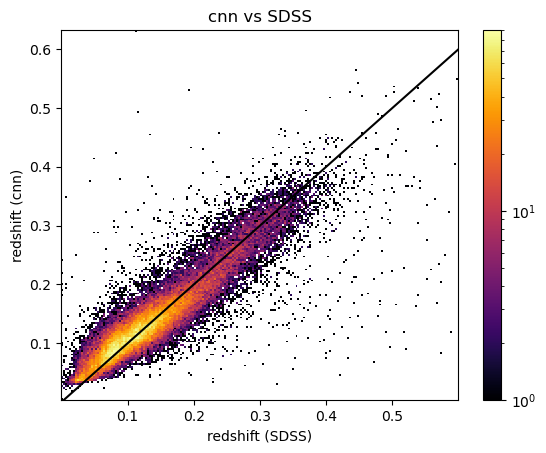

In [61]:
BINS = 200
CMAP = 'inferno'

plt.figure()
plt.hist2d(redshifts_true, redshift_predicted, bins=BINS, norm=matplotlib.colors.LogNorm(), cmap=CMAP)
plt.plot([0, 0.6], [0, 0.6], '-', c='black')
plt.xlabel('redshift (SDSS)')
plt.ylabel('redshift (cnn)')
plt.colorbar()
plt.title("cnn vs SDSS")
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_hist2d.png')

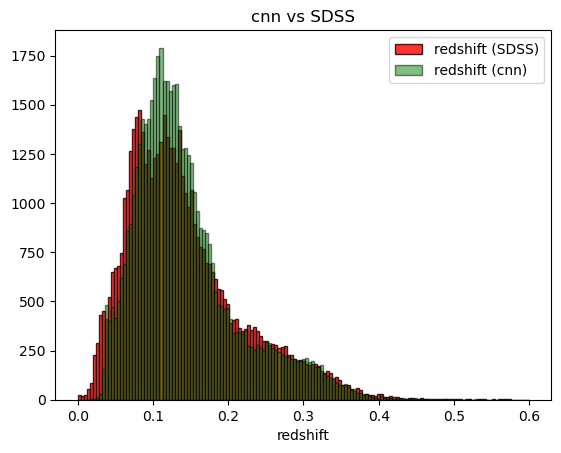

In [62]:
HIST_BIN_SCALE = 150

plt.figure()
plt.hist(redshifts_true, bins=np.linspace(min(redshifts_true), max(redshifts_true), HIST_BIN_SCALE), edgecolor='black', alpha=0.8, label='redshift (SDSS)', color='red')
plt.hist(redshift_predicted, bins=np.linspace(min(redshifts_true), max(redshifts_true), HIST_BIN_SCALE), edgecolor='black', alpha=0.5, label='redshift (cnn)', color='green')
plt.xlabel('redshift')
plt.title("cnn vs SDSS")
plt.legend()
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_hist.png')

In [63]:
BIN_SIZE = 0.05

absolute_error = redshift_predicted - redshifts_true
bins = np.arange(0, max(redshifts_true) + BIN_SIZE, BIN_SIZE)
bin_indices = np.digitize(redshifts_true, bins)
mean_errors = [np.mean(absolute_error[bin_indices == i]) for i in range(1, len(bins))]
std_errors = [np.std(absolute_error[bin_indices == i]) for i in range(1, len(bins))]

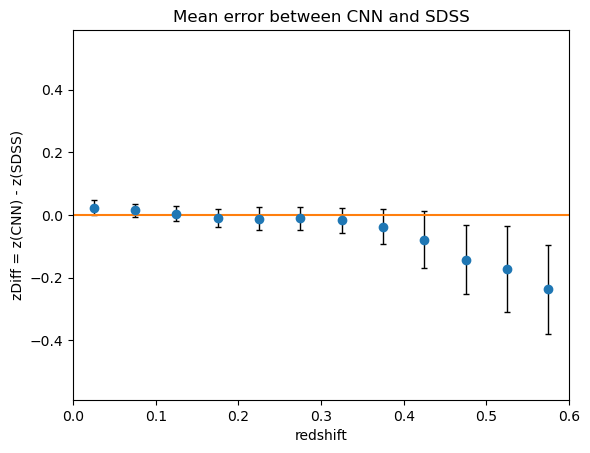

In [64]:
bin_centers = (bins[:-1] + bins[1:]) / 2

plt.figure()
plt.errorbar(bin_centers, mean_errors, yerr=std_errors, fmt='o', ecolor='black', capsize=2, elinewidth=1, markeredgewidth=1, label='Mean error')
plt.plot([0, 0.6], [0, 0])
plt.xlabel('redshift')
plt.ylabel('zDiff = z(CNN) - z(SDSS)')
plt.ylim([-0.59, 0.59])
plt.xlim([0, 0.6])
plt.title(f"Mean error between CNN and SDSS")
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_mae_errorbar.png')

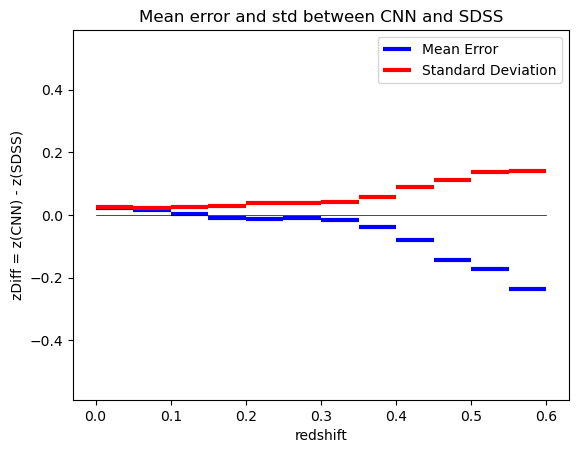

In [65]:
plt.figure()
plt.hlines(mean_errors, bins[:-1], bins[1:], colors=['blue'], linewidth=3.0, label='Mean Error')
plt.hlines(std_errors, bins[:-1], bins[1:], colors=['red'], linewidth=3.0, label='Standard Deviation')
plt.plot([0, 0.6], [0, 0], c='black', linewidth=0.5)
plt.xlabel('redshift')
plt.ylabel('zDiff = z(CNN) - z(SDSS)')
plt.ylim([-0.59, 0.59])
plt.title(f"Mean error and std between CNN and SDSS")
plt.legend()
if SAVE_FIGURES: plt.savefig('./graphs/cnn_vs_sdss_mae.png')

In [66]:
print("| redshift bin | mean error | std error |")
print("|--------------|------------| --------- |")
for i in range(len(mean_errors)):
    print(f"| {bins[i]:.2f} - {bins[i+1]:.2f} | {mean_errors[i]:.4f} | {std_errors[i]:.4f} |")

| redshift bin | mean error | std error |
|--------------|------------| --------- |
| 0.00 - 0.05 | 0.0234 | 0.0242 |
| 0.05 - 0.10 | 0.0148 | 0.0215 |
| 0.10 - 0.15 | 0.0032 | 0.0239 |
| 0.15 - 0.20 | -0.0089 | 0.0283 |
| 0.20 - 0.25 | -0.0128 | 0.0366 |
| 0.25 - 0.30 | -0.0100 | 0.0366 |
| 0.30 - 0.35 | -0.0178 | 0.0411 |
| 0.35 - 0.40 | -0.0378 | 0.0556 |
| 0.40 - 0.45 | -0.0790 | 0.0907 |
| 0.45 - 0.50 | -0.1427 | 0.1113 |
| 0.50 - 0.55 | -0.1735 | 0.1368 |
| 0.55 - 0.60 | -0.2379 | 0.1414 |


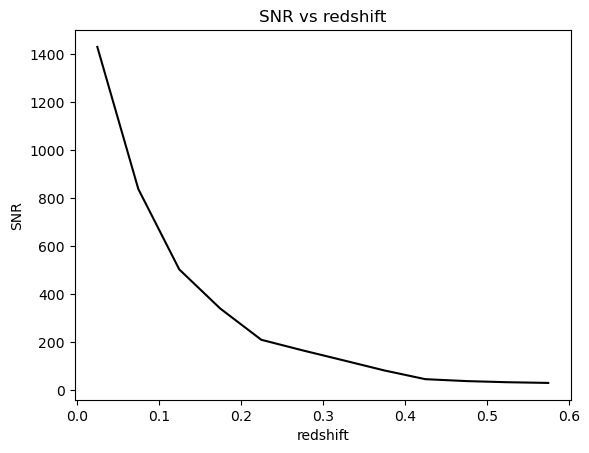

In [67]:
total_flux = np.sum(spectra_to_predict, axis=1)

bin_indices = np.digitize(redshifts_true, bins)
mean_fluxes = [np.mean(total_flux[bin_indices == i]) for i in range(1, len(bins))]

snr = np.array(mean_fluxes) / np.array(std_errors)

plt.figure()
plt.plot(bin_centers, snr, label='SNR', c='black')
plt.xlabel('redshift')
plt.ylabel('SNR')
plt.title(f"SNR vs redshift")
if SAVE_FIGURES: plt.savefig('./graphs/snr.png')

plt.show()
